In [ ]:
! pip install -q kaggle


Мы скачали данные. Давайте ниже напишем класс датасета. Формат данных у нас следующий: если в названии файла есть cat, то на картинке котик. А если dog, то пёсик.

In [ ]:
import numpy as np
import pandas as pd
from glob import glob

import torch
from torch import nn

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import os
from tqdm import tqdm
from tempfile import TemporaryDirectory

from PIL import Image

Подготовим данные и разделим их на трейн и тест

In [ ]:
images = glob("./dogcat/train/*.jpg")

In [ ]:
train, test = train_test_split(images, test_size = 0.3, random_state=42)

In [ ]:
class CatDogDataset(Dataset):

    def __init__(self, paths, transform = None):

        self.paths = paths
        self.transform = transform


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.paths[index].split("/")[-1].split(".")[0]

        label = 0 if label == 'cat' else 1

        image = Image.open(self.paths[index])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# Сделаем просто ресайз и нормалайз
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import matplotlib.pyplot as plt

def imshow(inp):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
data = {"train": train, "val" : test}
image_datasets = {x: CatDogDataset(data[x], transform=data_transform)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


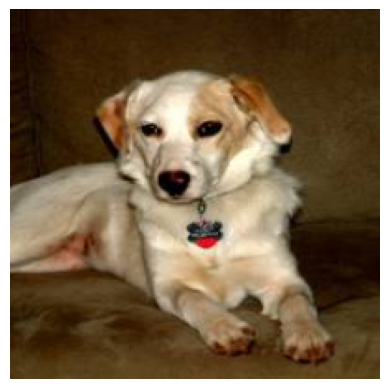

In [ ]:
# Отрисуем одну картинку
imshow(image_datasets["train"].__getitem__(0)[0])

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
class_names = {0 : "cat", 1:"dog"}

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[int(preds[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

!pip install torchinfo


import torchvision

from torchinfo import summary

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## Задание 3. Обучите модель на 5 эпохах и запомните (или запишите) accuracy. Это понадобится для ответа на вопрос теста. Запомните и качество после первой эпохи.

Будьте готовы, что обучение займет минут 10 на ГПУ в коллабе. Это ещё быстро...

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


Epoch 0/4
----------


100%|██████████| 547/547 [01:29<00:00,  6.09it/s]


train Loss: 0.1796 Acc: 0.9267


100%|██████████| 235/235 [00:41<00:00,  5.71it/s]


val Loss: 0.1177 Acc: 0.9527

Epoch 1/4
----------


100%|██████████| 547/547 [01:24<00:00,  6.50it/s]


train Loss: 0.1194 Acc: 0.9541


100%|██████████| 235/235 [00:32<00:00,  7.33it/s]


val Loss: 0.1254 Acc: 0.9472

Epoch 2/4
----------


100%|██████████| 547/547 [01:43<00:00,  5.27it/s]


train Loss: 0.0875 Acc: 0.9655


100%|██████████| 235/235 [00:32<00:00,  7.27it/s]


val Loss: 0.1194 Acc: 0.9547

Epoch 3/4
----------


100%|██████████| 547/547 [01:24<00:00,  6.47it/s]


train Loss: 0.0789 Acc: 0.9690


100%|██████████| 235/235 [00:32<00:00,  7.29it/s]


val Loss: 0.1209 Acc: 0.9505

Epoch 4/4
----------


100%|██████████| 547/547 [01:24<00:00,  6.46it/s]


train Loss: 0.0645 Acc: 0.9758


100%|██████████| 235/235 [00:32<00:00,  7.30it/s]


val Loss: 0.1050 Acc: 0.9559

Training complete in 10m 18s
Best val Acc: 0.955867


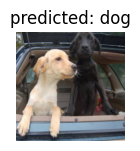

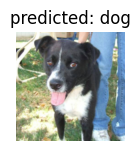

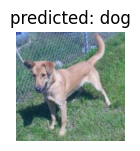

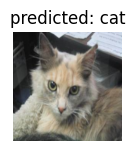

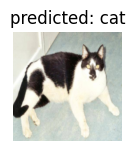

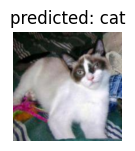

Общее количество параметров в модели: 11177538


In [ ]:
# Инициализация модели ResNet18
model = torchvision.models.resnet18(pretrained=True)

# Изменение последнего полносвязного слоя для соответствия количеству классов (2 класса: кошка и собака)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Перенос модели на соответствующее устройство (GPU или CPU)
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели на 5 эпохах
trained_model = train_model(model, criterion, optimizer, num_epochs=5)

# Визуализация предсказаний модели
visualize_model(trained_model)

# Подсчет параметров модели
total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров в модели: {total_params}")


## Задание 4. Сделайте то же самое, только без предобученной архитектуры. Это задается параметром weights со значением None. Стало ли качество лучше? Запомните и его.

Epoch 0/4
----------


100%|██████████| 547/547 [01:24<00:00,  6.47it/s]


train Loss: 0.6559 Acc: 0.6245


100%|██████████| 235/235 [00:31<00:00,  7.56it/s]


val Loss: 0.6513 Acc: 0.6709

Epoch 1/4
----------


100%|██████████| 547/547 [01:27<00:00,  6.25it/s]


train Loss: 0.5725 Acc: 0.7002


100%|██████████| 235/235 [00:33<00:00,  7.07it/s]


val Loss: 0.5199 Acc: 0.7489

Epoch 2/4
----------


100%|██████████| 547/547 [01:28<00:00,  6.21it/s]


train Loss: 0.4892 Acc: 0.7647


100%|██████████| 235/235 [00:33<00:00,  7.03it/s]


val Loss: 0.4633 Acc: 0.7792

Epoch 3/4
----------


100%|██████████| 547/547 [01:27<00:00,  6.28it/s]


train Loss: 0.4289 Acc: 0.8040


100%|██████████| 235/235 [00:32<00:00,  7.19it/s]


val Loss: 0.5284 Acc: 0.7392

Epoch 4/4
----------


100%|██████████| 547/547 [01:28<00:00,  6.17it/s]


train Loss: 0.3496 Acc: 0.8449


100%|██████████| 235/235 [00:32<00:00,  7.16it/s]


val Loss: 0.4117 Acc: 0.8220

Training complete in 9m 60s
Best val Acc: 0.822000


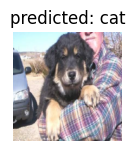

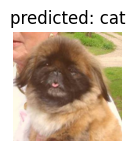

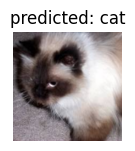

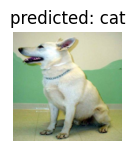

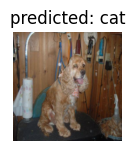

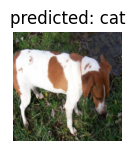

Общее количество параметров в модели: 11177538


In [ ]:
# Инициализация модели ResNet18 без предобученных весов
model_zero = torchvision.models.resnet18(weights=None)

# Изменение последнего полносвязного слоя для соответствия количеству классов (2 класса: кошка и собака)
num_ftrs = model_zero.fc.in_features
model_zero.fc = nn.Linear(num_ftrs, 2)

# Перенос модели на соответствующее устройство (GPU или CPU)
model_zero = model_zero.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_zero.parameters(), lr=0.001)

# Обучение модели на 5 эпохах
trained_model = train_model(model_zero, criterion, optimizer, num_epochs=5)

# Визуализация предсказаний модели
visualize_model(trained_model)

# Подсчет параметров модели
total_params = sum(p.numel() for p in model_zero.parameters())
print(f"Общее количество параметров в модели: {total_params}")


In [ ]:
# TRAIN MODEL ZERO HERE

Посмотрим чему научилась наша модель, обученная с 0:

Epoch 0/4
----------


100%|██████████| 547/547 [01:27<00:00,  6.28it/s]


train Loss: 0.6577 Acc: 0.6135


100%|██████████| 235/235 [00:32<00:00,  7.19it/s]


val Loss: 0.6061 Acc: 0.6751

Epoch 1/4
----------


100%|██████████| 547/547 [01:26<00:00,  6.31it/s]


train Loss: 0.5791 Acc: 0.6928


100%|██████████| 235/235 [00:32<00:00,  7.19it/s]


val Loss: 0.5570 Acc: 0.7352

Epoch 2/4
----------


100%|██████████| 547/547 [01:26<00:00,  6.29it/s]


train Loss: 0.4902 Acc: 0.7607


100%|██████████| 235/235 [00:33<00:00,  7.07it/s]


val Loss: 0.4617 Acc: 0.7816

Epoch 3/4
----------


100%|██████████| 547/547 [01:27<00:00,  6.27it/s]


train Loss: 0.4087 Acc: 0.8119


100%|██████████| 235/235 [00:33<00:00,  7.06it/s]


val Loss: 0.4297 Acc: 0.8011

Epoch 4/4
----------


100%|██████████| 547/547 [01:27<00:00,  6.22it/s]


train Loss: 0.3455 Acc: 0.8467


100%|██████████| 235/235 [00:32<00:00,  7.20it/s]


val Loss: 0.3118 Acc: 0.8635

Training complete in 10m 1s
Best val Acc: 0.863467
Общее количество параметров в модели: 11177538


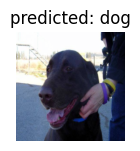

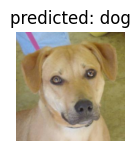

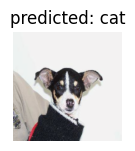

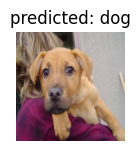

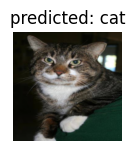

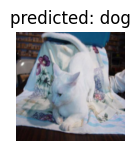

In [ ]:
# Инициализация модели ResNet18 без предобученных весов
model_zero = torchvision.models.resnet18(weights=None)

# Изменение последнего полносвязного слоя для соответствия количеству классов (2 класса: кошка и собака)
num_ftrs = model_zero.fc.in_features
model_zero.fc = nn.Linear(num_ftrs, 2)

# Перенос модели на соответствующее устройство (GPU или CPU)
model_zero = model_zero.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_zero.parameters(), lr=0.001)

# Обучение модели на 5 эпохах
trained_model = train_model(model_zero, criterion, optimizer, num_epochs=5)

# Подсчет параметров модели
total_params = sum(p.numel() for p in model_zero.parameters())
print(f"Общее количество параметров в модели: {total_params}")

# Визуализация предсказаний модели
visualize_model(trained_model)

# Если требуется, чтобы графики отобразились сразу:
plt.ioff()
plt.show()


In [ ]:
visualize_model(model_zero)

plt.ioff()
plt.show()

NameError: name 'model_zero' is not defined

А с претрейном:

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


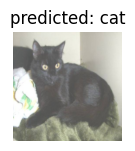

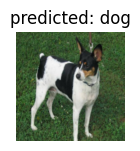

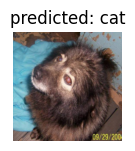

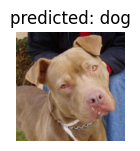

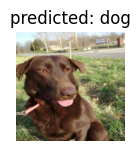

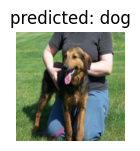

In [ ]:
visualize_model(model)

plt.ioff()
plt.show()

Отлично, вы справились с задачей и изучили основы компьютерного зрения! Дальше нас ждет захватывающий мир современного CV.
